In [1]:
!pip install pomegranate

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
!conda install -c anaconda graphviz python-graphviz -y

In [ ]:
!pip install --install-option="--include-path=/srv/conda/envs/notebook/include"  --install-option="--library-path=/srv/conda/envs/notebook/lib" pygraphviz

In [ ]:
!pip install matplotlib
!pip install pillow

In [ ]:
import pygraphviz
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image

In [ ]:
def plot(nw):
    G = pygraphviz.AGraph(directed=True)
    for state in nw.states:
        G.add_node(state.name, color='red')
    for parent, child in nw.edges:
        G.add_edge(parent.name, child.name)
    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = matplotlib.image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')

## Bayesian Network

In [2]:
from pomegranate import *

In [3]:
attack = DiscreteDistribution( { True: 0.01, False: 0.99 } )
_attack_node = State(attack, name="attack")

In [4]:
AV = ConditionalProbabilityTable([
    [ True, True,  0.9 ],  #TruePositive
    [ True, False, 0.1 ],  #TrueNegative
    [ False, True, 0.005 ],#FalsePositive
    [ False, False,0.995 ] #FalseNegative
    ], [attack])
_AV_node = State(AV, name="AV")

In [5]:
FW = ConditionalProbabilityTable([
    [ True, True,  0.7 ],   #TruePositive
    [ True, False, 0.3 ],   #TrueNegative
    [ False, True, 0.0001 ],#FalsePositive
    [ False, False,0.9999 ] #FalseNegative
    ], [attack])
_FW_node = State(FW, name="FW")

In [6]:
#Building the Bayesian Network
network = BayesianNetwork("Security Alert With Bayesian Networks")
network.add_nodes(_attack_node, _AV_node, _FW_node)
network.add_edge(_attack_node, _AV_node)
network.add_edge(_attack_node, _FW_node)
network.bake()

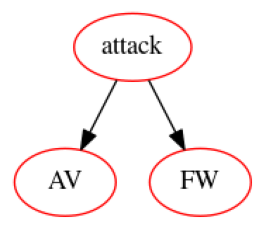

In [7]:
#network.plot()
plot(network)

In [8]:
beliefs = network.predict_proba({ 'FW':True, 'AV':True })
for state, belief in zip(network.states, beliefs):
    print(state.name, belief)

attack {
    "class" :"Distribution",
    "dtype" :"bool",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "True" :0.9999214347444128,
            "False" :7.856525558718288e-05
        }
    ],
    "frozen" :false
}
AV True
FW True


In [9]:
beliefs = network.predict_proba({ 'FW':False, 'AV':False })
for state, belief in zip(network.states, beliefs):
    print(state.name, belief)

attack {
    "class" :"Distribution",
    "dtype" :"bool",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "True" :0.0003044907838481176,
            "False" :0.9996955092161519
        }
    ],
    "frozen" :false
}
AV False
FW False


## Multilayer

In [10]:
AVt = ConditionalProbabilityTable([
    [ True, True,  1.0 ],
    [ True, False, 0.0 ],
    [ False,True,  0.0 ],
    [ False,False, 1.0 ]
    ], [attack])
_AVt_node = State(AVt, name="AVt")

In [11]:
AV = ConditionalProbabilityTable([
    [ True, True,  0.9 ],  #TruePositive
    [ True, False, 0.1 ],  #TrueNegative
    [ False, True, 0.005 ],#FalsePositive
    [ False, False,0.995 ] #FalseNegative
    ], [AVt])
_AV_node = State(AV, name="AV")

In [12]:
WL = ConditionalProbabilityTable([
    [ True, True,  0.1 ],
    [ True, False, 0.9 ],
    [ False, True, 0.9 ],
    [ False, False,0.1 ]
    ], [AVt])
_WL_node = State(WL, name="WL")

In [13]:
#Building the Bayesian Network
network = BayesianNetwork("Security Alert With Bayesian Networks")
network.add_nodes(_attack_node, _AVt_node, _AV_node, _WL_node, _FW_node)
network.add_edge(_attack_node, _AVt_node)
network.add_edge(_AVt_node, _AV_node)
network.add_edge(_AVt_node, _WL_node)
network.add_edge(_attack_node, _FW_node)
network.bake()

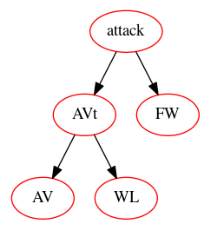

In [14]:
#network.plot()
plot(network)

In [15]:
beliefs = network.predict_proba({ 'FW':False, 'AV':True, 'WL':True })
for state, belief in zip(network.states, beliefs):
    print(state.name, belief)

attack {
    "class" :"Distribution",
    "dtype" :"bool",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "True" :0.05714824540599343,
            "False" :0.9428517545940066
        }
    ],
    "frozen" :false
}
AVt {
    "class" :"Distribution",
    "dtype" :"bool",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "False" :0.9428517545939963,
            "True" :0.057148245406003655
        }
    ],
    "frozen" :false
}
AV True
WL True
FW False


## XSS

In [16]:
import pandas as pd
# Ref: https://www.kaggle.com/syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning
data = pd.read_csv("XSS_dataset.csv")
data.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [17]:
data.query("Label == 1").shape[0], data.shape[0]

(7373, 13686)

In [18]:
xss_datasets = []
features = ["alert", "script", "span", "mouseover", "href", "http", "document"]
for idx, row in data.iterrows():
    s, l = row[1], row[2]
    s = s.lower()
    d = []
    for fe in features:
        d.append(fe if s.find(fe) != -1 else "no_" + fe)
    xss_datasets.append(d)

In [19]:
network = BayesianNetwork("XSS Tree With Bayesian Networks")
network = network.from_samples(xss_datasets)

0 alert
1 script
2 span
3 mouseover
4 href
5 http
6 document


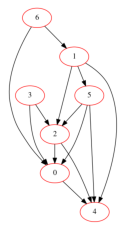

In [20]:
for i, fe in enumerate(features):
    print(i, fe)
#network.plot()
plot(network)

In [21]:
beliefs = network.predict_proba({  })
for state, belief in zip(network.states, beliefs):
    print(state.name, belief)

0 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "no_alert" :0.48320678212131846,
            "alert" :0.5167932178786815
        }
    ],
    "frozen" :false
}
1 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "no_script" :0.9812947537629686,
            "script" :0.018705246237031473
        }
    ],
    "frozen" :false
}
2 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "span" :0.2234274003640017,
            "no_span" :0.7765725996359983
        }
    ],
    "frozen" :false
}
3 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "mouseover" :0.011033172585124141,
            "no_mouseover" :0.9889668274148758
        }
    ],
    "frozen" 

In [22]:
beliefs = network.predict_proba({ '3':'mouseover', '0':'alert' })
for state, belief in zip(network.states, beliefs):
    print(state.name, belief)

0 alert
1 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "no_script" :0.9819271998866937,
            "script" :0.01807280011330617
        }
    ],
    "frozen" :false
}
2 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "span" :0.01659623409638092,
            "no_span" :0.9834037659036191
        }
    ],
    "frozen" :false
}
3 mouseover
4 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "no_href" :0.9888178370528234,
            "href" :0.01118216294717661
        }
    ],
    "frozen" :false
}
5 {
    "class" :"Distribution",
    "dtype" :"numpy.str_",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "no_http" :0.9800843880274941,
            "http" :0.019915611972505794
        }
    ],
    "